In [2]:
import string
import itertools
import numpy as np
import pandas as pd
import glob

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.1, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [4]:
import mdtraj as md

# Analysis of interactions

In [5]:
def unit_normal_vector(v1, v2):
    """Calculates the unit normal vector to a plane defined by two vectors.

    Args:
        v1: The first vector defining the plane.
        v2: The second vector defining the plane.

    Returns:
        The unit normal vector to the plane.
    """

    normal = np.cross(v1, v2, axisa=1)
    norm = np.linalg.norm(normal, axis=1).reshape(np.shape(normal)[0],1)
    normal = normal / norm
    return normal

In [6]:
def get_normal(coords, id, sidechain_atoms):
    """
    Calculate the normal vector to the plane defined by three atoms

    Parameters
    ----------
        coords: 
            The coordinates of the atoms
    Returns
    -------
        normal: 
            The normal vector to the plane defined by the three atoms

    """
    try: 
        i, j, k = [x.index for x in coords.topology.residue(id).atoms if x.name in sidechain_atoms]
        displacements = md.compute_displacements(coords, [[i,j], [i,k]])
        normal = unit_normal_vector(displacements[:,0,:], displacements[:,1,:])
        return normal
    except ValueError as e:
        print (e)
        return None

In [7]:
pdb_name = []
theta = []; theta1 = []; theta2 = []
dmin = []
dmean = []
for pdb_file in glob.glob('structures/*.pdb'):
    print (pdb_file)
    pdb_name.append(pdb_file.split('/')[-1].split('.pdb')[0])
    pdb_coords = md.load_pdb(pdb_file)
    print (pdb_coords.topology.to_dataframe())

    # compute minimum distance between aromatic and charged sidechains
    aro_side = pdb_coords.top.select('element C and resname PHE TYR and name != "CB"')
    charged_side = pdb_coords.top.select('element N and resname ARG LYS')
    atom_pairs = list(itertools.product(aro_side, charged_side))
    #print (aro_side)
    #print (charged_side)
    dmin.append(np.min((md.compute_distances(pdb_coords, atom_pairs=atom_pairs, \
                                          periodic=False))))

    # compute displacement vector between aromatic and charged sidechains
    displacement = md.compute_displacements(pdb_coords, \
                list(itertools.product(charged_side, aro_side)), periodic=False)[0]
    dvec = np.mean(displacement, axis=0)
    dvec_mod = np.linalg.norm(dvec)
    dmean.append(dvec_mod)
    dvec_unit = dvec/dvec_mod
    
    # Compute the normal vector to the plane defined by the sidechain atoms
    n_i = get_normal(pdb_coords, 0, ['CB', 'CR1', 'CR2'])
    #print ([np.arccos((n_i*dvec_unit).sum())*180/np.pi, \
    #                np.arccos((-n_i*dvec_unit).sum())*180/np.pi])
    theta1.append(np.min([np.arccos((n_i*dvec_unit).sum()), \
                    np.arccos((-n_i*dvec_unit).sum())]))
    
    # For arginine, compute the normal vector to the guanidinium group plane
    if 'Arg' in pdb_file:
        n_j = get_normal(pdb_coords, 1, [a.name for a in pdb_coords.topology.atoms \
                                     if 'N' in a.name])
        theta.append(np.min([np.arccos((n_j*n_i).sum()), \
            np.arccos((-n_j*n_i).sum())]))
        theta2.append(np.min([np.arccos((n_j*dvec_unit).sum()), \
            np.arccos((-n_j*dvec_unit).sum())]))
    else:
        theta.append(None)
        theta2.append(None)
contacts_qm_df = pd.DataFrame({'pdb': pdb_name, 'dmean':dmean, 'dmin': dmin, 'theta': theta, 'theta1': theta1, 'theta2': theta2})
#contacts_df = pd.DataFrame({'pdb': pdb_name, 'dmin': dmin, 'theta1': np.array(theta1)*180/np.pi})

structures/ArgPhe.pdb
(    serial name element  resSeq resName  chainID segmentID  formal_charge
0        1  CR1       C       1     PHE        0                     <NA>
1        2  CR2       C       1     PHE        0                     <NA>
2        3  CR3       C       1     PHE        0                     <NA>
3        4  CR4       C       1     PHE        0                     <NA>
4        5  CR5       C       1     PHE        0                     <NA>
5        6  CR6       C       1     PHE        0                     <NA>
6        7   CB       C       1     PHE        0                     <NA>
7        8   C1       C       2     ARG        0                     <NA>
8        9   N2       N       2     ARG        0                     <NA>
9       10   N3       N       2     ARG        0                     <NA>
10      11   C4       C       2     ARG        0                     <NA>
11      12   C5       C       2     ARG        0                     <NA>
12      13   N6

In [8]:
contacts_qm_df

,pdb,dmean,dmin,theta,theta1,theta2
0,ArgPhe,0.364952,0.340676,0.172121,0.386093,0.547266
1,LysTyr,0.419565,0.334311,NaN,0.854846,NaN
2,ArgPheT,0.405896,0.336983,1.541393,0.124926,1.514827
3,LysPhe,0.323791,0.345352,NaN,0.057300,NaN
4,ArgTyrT,0.431030,0.335830,1.365738,0.526130,1.339233
5,ArgTyrP,0.351516,0.343716,0.039236,0.346643,0.385378
6,ArgTyr,0.528022,0.367168,1.491288,1.523842,1.039782


In [9]:
contacts_qm_df.to_csv("contacts_qm_df.csv")

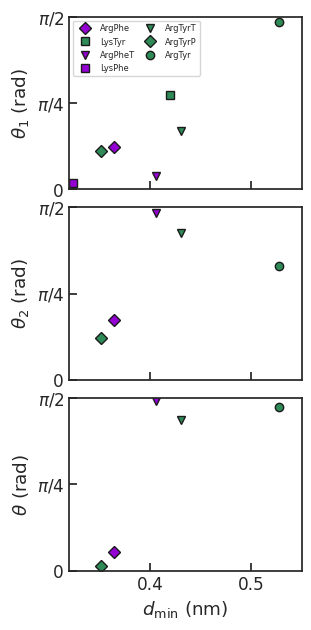

In [12]:
fig, ax = plt.subplots(3,1, figsize=(3.5,6.5), sharex=True, sharey=True)
for i,v in contacts_qm_df.iterrows():
    color = ['seagreen' if 'Tyr' in v['pdb'] else 'darkviolet'][0]

    symbol = 'o'
    if 'Lys' in v['pdb']:
        symbol = 's'
    elif 'TyrT' in v['pdb'] or 'PheT' in v['pdb']:
        symbol = 'v'
    elif 'TyrP' in v['pdb'] or 'Phe' in v['pdb']:
        symbol = 'D'
    ax[0].plot(v['dmean'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
    ax[1].plot(v['dmean'], v['theta2'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
    ax[2].plot(v['dmean'], v['theta'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax[0].set_xlim(0.32, 0.55)
ax[0].set_ylim(0, np.pi/2)
ax[0].set_yticks([0, np.pi/4, np.pi/2])
ax[0].set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax[0].set_ylabel(r'$\theta_1$ (rad)')
ax[1].set_ylabel(r'$\theta_2$ (rad)')
ax[2].set_ylabel(r'$\theta$ (rad)')
ax[-1].set_xlabel('$d_\mathrm{min}$ (nm)')
ax[0].legend(fontsize=6, loc=2, ncols=2, columnspacing=0.8)
plt.tight_layout(h_pad=0)

## Combine with PDB data

In [14]:
culled = "../PDBanalysis/cullpdb_pc15.0_res0.0-1.5_len40-10000_R0.25_Xray_d2025_02_19_chains1916.txt"
with open(culled, 'r') as f:
    raw = f.readlines()
pdbids = [r.split()[0] for r in raw][1:]
print(pdbids)

['5D8VA', '3NIRA', '5NW3A', '1UCSA', '3X2MA', '2VB1A', '1US0A', '6E6OA', '6S2MA', '1R6JA', '4REKA', '4I8HA', '2WFIA', '2OV0A', '2B97A', '8C5NA', '3X34A', '7KR0A', '6L27A', '5YCEA', '1GCIA', '7A5MA', '5GV8A', '6ZM8A', '1X6ZA', '4UA6A', '5TDAA', '7AF2AAA', '3UI4A', '5AL6A', '5NFMA', '1W0NA', '5HB7A', '2VXNA', '1NWZA', '8C3XA', '7AVKA', '2JFRA', '2O9SA', '4Y9WA', '6TGUA', '1P9GA', '7BNHA', '2O7AA', '2YKZA', '4EICA', '6EIOA', '4PSSA', '4AYOA', '6Q00A', '6Q00B', '3O4PA', '6ETLA', '1MC2A', '1X8QA', '7BBXA', '7AOTA', '3QPAA', '2FMAA', '5XVTA', '2F01A', '1G6XA', '3WDNA', '1MUWA', '3ZSJA', '6ZPAA', '2DDXA', '1V6PA', '8EREA', '4HS1A', '5L87A', '1GWEA', '3ZOJA', '3FILA', '4F1VA', '5LP9A', '1I1WA', '4U9HL', '4U9HS', '6KFNA', '8JZ8A', '7TVLA', '4O6UA', '4UYRA', '3IP0A', '8PB5A', '8AVUA', '4WEEA', '4Y9VA', '1IX9A', '6KLZA', '7OUZA', '6FMCA', '4NPDA', '1VYRA', '8VOLA', '7PSYA', '3VORA', '3G21A', '5GJIA', '3ZR8X', '4EA9A', '2XU3A', '6LK1A', '1J0PA', '5IG6A', '5BR4A', '3X0IA', '8CR4A', '5MK9A', '4HNOA'

In [30]:
pdb_coords = {}
res_names = ['PHE', 'TYR', 'ARG', 'LYS']
# Loop over all PDB files
for prot in pdbids[:50]:
    try:
        # Load the PDB file
        pdb_file = md.load_pdb("../PDBanalysis/PDB/pdb%s.ent"%prot.lower()[:4])
    except FileNotFoundError as e:
        print ("File %s not found" % (prot[:4]))
        #print (e)
        continue

    # Select the chain ID from the PDB file
    try:
        chainid = string.ascii_uppercase.index(prot[4])
    except ValueError as e:
        print (e)
        print (prot)
        continue

    try:
        sel = pdb_file.top.select('chainid %i'%chainid)
        pdb_file = pdb_file.atom_slice(sel)
    except IndexError as e:
        print ("Chain %s not found in %s" % (prot[4], prot[:4]))
        continue

    # Select residues
    try:
        sel = []
        for name in res_names:
            sel += list(pdb_file.top.select('resname %s and symbol != H'%name))
        sel = sorted(sel)
    except Exception as e:
        print (e)
        break
    pdb_coords[prot] = pdb_file[0].atom_slice((sel)) 

File 7AF2 not found


In [31]:
contacts = {}
aro_sidechain = ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']
charged_sidechain = ['NZ', 'NE', 'NH1', 'NH2']

pdb_ids = []
resSeqs_i = []; resSeqs_j = []
codes_i = []; codes_j = []
dmins = []; dvecs = []
thetas = []; theta1s = []; theta2s = []; ttheta1s = []; ttheta2s = [] 

for pdb, coords in pdb_coords.items(): # Loop over PDB files
    print (pdb)
    print (coords.top)
    #print ([coords.topology.residue(i).code for i in range(coords.topology.n_residues)])
    res_pairs = list(itertools.combinations(range(coords.topology.n_residues), 2))
    try:
        dist, pairs = md.compute_contacts(coords, res_pairs, periodic=False, scheme='sidechain-heavy')
    except ValueError as e:
        print (e)
        continue
    #print (list(zip(dist[0], pairs)))
    for k, d in enumerate(dist.ravel()):
        if d < 0.45:
            i, j = pairs[k][0], pairs[k][1]
            ires, jres = coords.topology.residue(i), coords.topology.residue(j)
            iseq,  jseq = coords.topology.residue(i).resSeq, coords.topology.residue(j).resSeq
            ic, jc = coords.topology.residue(i).code, coords.topology.residue(j).code

            ii, ji = coords.topology.residue(i).resSeq, coords.topology.residue(j).resSeq
            id, jd = coords.topology.residue(i).code, coords.topology.residue(j).code

            # Compute vector between sidechains
            if ic in ['F', 'Y']:
                isel = [x.index for x in coords.topology.residue(i).atoms if \
                               x.name in aro_sidechain]
            elif ic in ['R', 'K']:    
                isel = [x.index for x in coords.topology.residue(i).atoms if \
                               x.name in charged_sidechain]
            if jc in ['F', 'Y']:
                jsel = [x.index for x in coords.topology.residue(j).atoms if \
                               x.name in aro_sidechain]
            elif jc in ['R', 'K']:    
                jsel = [x.index for x in coords.topology.residue(j).atoms if \
                               x.name in charged_sidechain]
            try:
                displacement = md.compute_displacements(coords, \
                                            list(itertools.product(isel, jsel)), periodic=False)[0]
                dvec = np.mean(displacement, axis=0)
                dvec_mod = np.linalg.norm(dvec)
                dvec_unit = dvec/dvec_mod
            except ValueError as e:
                print (e)
                print ("Not enough atoms in residue pair: ", iseq, jseq)
                dvec = None
                dvec_mod = None
                dvec_unit = None
                continue
            
            # Compute the normal vector to the plane defined by the sidechain atoms
            if id in ['F', 'Y']:
                n_i = get_normal(coords, i, aro_sidechain[:3])
            elif id in ['R']:
                n_i = get_normal(coords, i, charged_sidechain[1:])
            else:
                n_i = None

            if jd in ['F', 'Y']:
                n_j = get_normal(coords, j, aro_sidechain[:3])
            elif jd in ['R']:
                n_j = get_normal(coords, j, charged_sidechain[1:])
            else:
                n_j = None
            
            theta = None; theta1 = None; theta2 = None
            ttheta1 = None; ttheta2 = None # set angles to none by default
            try:
                theta = np.min([np.arccos((n_i*n_j).sum()), np.arccos((-n_i*n_j).sum())])
            except TypeError as e:
                theta = None

            try:
                if id in ['F']:
                    if jd in ['F', 'Y']:
                        ttheta1 = np.pi/2 - np.min([np.arccos((n_i*dvec_unit).sum()), \
                                                    np.arccos((-n_i*dvec_unit).sum())])
                        ttheta2 = np.pi/2 - np.min([np.arccos((n_j*dvec_unit).sum()), \
                                                    np.arccos((-n_j*dvec_unit).sum())])
                    elif jd in ['K', 'R']:
                        theta1 = np.min([np.arccos((n_i*dvec_unit).sum()), \
                                         np.arccos((-n_i*dvec_unit).sum())])
                        theta2 = [np.min([np.arccos((n_j*dvec_unit).sum()), \
                                          np.arccos((-n_j*dvec_unit).sum())]) if jd in ['R'] else None][0]
                elif id in ['Y']:
                    if jd in ['F', 'Y']:
                        ttheta1 = np.pi/2 - np.min([np.arccos((n_j*dvec_unit).sum()), \
                                                    np.arccos((-n_j*dvec_unit).sum())])
                        ttheta2 = np.pi/2 - np.min([np.arccos((n_i*dvec_unit).sum()), \
                                                    np.arccos((-n_i*dvec_unit).sum())])
                    elif jd in ['K', 'R']:
                        theta1 = np.min([np.arccos((n_i*dvec_unit).sum()), \
                                         np.arccos((-n_i*dvec_unit).sum())])
                        theta2 = [np.min([np.arccos((n_j*dvec_unit).sum()), \
                                          np.arccos((-n_j*dvec_unit).sum())]) if jd in ['R'] else None][0]
                elif id in ['K', 'R']:
                    if jd in ['F', 'Y']:
                        theta1 = np.min([np.arccos((n_j*dvec_unit).sum()), \
                                         np.arccos((-n_j*dvec_unit).sum())])
                        theta2 = [np.min([np.arccos((n_i*dvec_unit).sum()), \
                                          np.arccos((-n_i*dvec_unit).sum())]) if id in ['R'] else None][0]
                    else:
                        theta1 = [np.min([np.arccos((n_i*dvec_unit).sum()), \
                                          np.arccos((-n_i*dvec_unit).sum())]) if id in ['R'] else None][0]
                        theta2 = [np.min([np.arccos((n_j*dvec_unit).sum()), \
                                          np.arccos((-n_j*dvec_unit).sum())]) if jd in ['R'] else None][0]
 
            except TypeError as e:
                print (e)

            pdb_ids.append(pdb)
            codes_i.append(ic); codes_j.append(jc)
            resSeqs_i.append(ires); resSeqs_j.append(jres)
            
            dmins.append(d)
            dvecs.append(dvec_mod)

            thetas.append(theta)
            theta1s.append(theta1); theta2s.append(theta2)
            ttheta1s.append(ttheta1); ttheta2s.append(ttheta2)
            
contacts_df = pd.DataFrame({'pdb': pdb_ids, 'res_i': codes_i, 'res_j': codes_j, 'resSeq_i': resSeqs_i, \
                            'resSeq_j': resSeqs_j, 'dmin': dmins, 'dvec' : dvecs, 'theta': thetas, \
                            'theta1': theta1s, 'theta2': theta2s, 'ttheta1': ttheta1s, 'ttheta2': ttheta2s})

5D8VA
<mdtraj.Topology with 1 chains, 10 residues, 101 atoms, 95 bonds>
3NIRA
<mdtraj.Topology with 1 chains, 5 residues, 57 atoms, 55 bonds>
5NW3A
<mdtraj.Topology with 1 chains, 9 residues, 192 atoms, 87 bonds>
1UCSA
<mdtraj.Topology with 1 chains, 6 residues, 59 atoms, 54 bonds>
3X2MA
<mdtraj.Topology with 1 chains, 20 residues, 216 atoms, 213 bonds>
2VB1A
<mdtraj.Topology with 1 chains, 23 residues, 244 atoms, 231 bonds>
1US0A
<mdtraj.Topology with 1 chains, 57 residues, 588 atoms, 560 bonds>
6E6OA
<mdtraj.Topology with 1 chains, 5 residues, 59 atoms, 58 bonds>
6S2MA
<mdtraj.Topology with 1 chains, 32 residues, 705 atoms, 301 bonds>
1R6JA
<mdtraj.Topology with 1 chains, 10 residues, 101 atoms, 95 bonds>
4REKA
<mdtraj.Topology with 1 chains, 90 residues, 967 atoms, 929 bonds>
4I8HA
<mdtraj.Topology with 1 chains, 29 residues, 301 atoms, 286 bonds>
2WFIA
<mdtraj.Topology with 1 chains, 39 residues, 407 atoms, 391 bonds>
2OV0A
<mdtraj.Topology with 1 chains, 18 residues, 186 atoms, 17

In [32]:
contacts_df

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
0,5D8VA,Y,F,TYR19,PHE64,0.448051,0.590764,0.913655,NaN,NaN,1.067686,1.153400
1,5D8VA,F,K,PHE64,LYS67,0.422619,0.794475,NaN,1.442892,NaN,NaN,NaN
2,3NIRA,R,F,ARG10,PHE13,0.433863,0.585247,1.233658,0.517593,0.875230,NaN,NaN
3,3NIRA,F,R,PHE13,ARG17,0.362366,0.657059,0.793855,0.978311,1.031952,NaN,NaN
4,5NW3A,K,F,LYS6,PHE48,0.310219,0.940045,NaN,0.882583,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
619,4AYOA,R,Y,ARG398,TYR403,0.347672,0.620735,1.478099,0.862381,1.053836,NaN,NaN
620,4AYOA,Y,F,TYR432,PHE436,0.378673,0.644522,0.108288,NaN,NaN,0.602005,0.495257
621,6Q00A,R,R,ARG42,ARG72,0.352106,0.399030,0.632911,0.014008,0.637769,NaN,NaN
622,6Q00A,R,Y,ARG54,TYR59,0.318754,0.464027,1.435412,0.462194,1.315434,NaN,NaN


### Arg - Tyr interactions

In [33]:
sel = pd.DataFrame([(contacts_df.res_i == 'Y') & (contacts_df.res_j == 'R'), \
                    (contacts_df.res_i == 'R') & (contacts_df.res_j == 'Y')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
29,2VB1A,Y,R,TYR20,ARG21,0.346485,0.477257,0.461955,0.697546,0.646792,NaN,NaN
34,2VB1A,Y,R,TYR53,ARG68,0.319916,0.697329,1.028186,1.468951,1.175047,NaN,NaN
41,1US0A,R,Y,ARG69,TYR103,0.331811,0.394170,0.177689,0.540974,0.468327,NaN,NaN
47,1US0A,Y,R,TYR189,ARG232,0.403743,0.662861,0.675075,1.364100,1.362535,NaN,NaN
49,1US0A,Y,R,TYR189,ARG293,0.379315,0.617137,0.943098,0.258059,1.060858,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
611,4AYOA,R,Y,ARG363,TYR423,0.316277,0.511959,0.362346,1.058707,0.739391,NaN,NaN
612,4AYOA,R,Y,ARG378,TYR444,0.332606,0.524392,0.656699,0.808989,0.600158,NaN,NaN
613,4AYOA,R,Y,ARG381,TYR382,0.333280,0.462538,0.990178,0.642418,0.425092,NaN,NaN
619,4AYOA,R,Y,ARG398,TYR403,0.347672,0.620735,1.478099,0.862381,1.053836,NaN,NaN


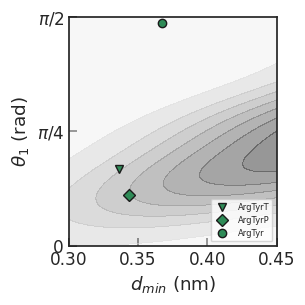

In [34]:
xmin = 0.3; xmax = 0.45
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Tyr' in v['pdb'] and 'Arg' in v['pdb']:
        color = ['seagreen' if 'Tyr' in v['pdb'] else 'darkviolet'][0]
        symbol = ['s' if 'Lys' in v['pdb'] else 'o'][0]
        if 'TyrT' in v['pdb']:
            symbol = 'v'
        elif 'TyrP' in v['pdb']:
            symbol = 'D'
        ax.plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

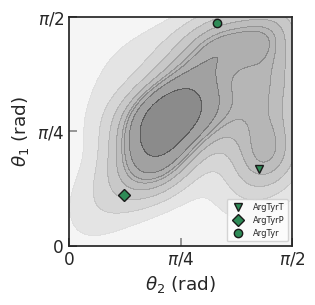

In [35]:
fig, ax = plt.subplots(figsize=(3.35, 3.25))

xmin = 0; xmax = np.pi/2
ymin = 0; ymax = np.pi/2
sns.kdeplot(data=contacts_df[sel], x='theta2', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)
for i,v in contacts_qm_df.iterrows():
    if 'Tyr' in v['pdb'] and 'Arg' in v['pdb']:
        color = ['seagreen' if 'Tyr' in v['pdb'] else 'darkviolet'][0]
        symbol = 'o'
        if 'TyrT' in v['pdb']:
            symbol = 'v'
        elif 'TyrP' in v['pdb']:
            symbol = 'D'
        ax.plot(v['theta2'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks([0, np.pi/4, np.pi/2])
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel(r'$\theta_2$ (rad)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

### Arg-Phe interactions

In [36]:
sel = pd.DataFrame([(contacts_df.res_i == 'F') & (contacts_df.res_j == 'R'), \
                    (contacts_df.res_i == 'R') & (contacts_df.res_j == 'F')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
2,3NIRA,R,F,ARG10,PHE13,0.433863,0.585247,1.233658,0.517593,0.875230,NaN,NaN
3,3NIRA,F,R,PHE13,ARG17,0.362366,0.657059,0.793855,0.978311,1.031952,NaN,NaN
18,3X2MA,R,F,ARG56,PHE58,0.357700,0.780990,0.976082,0.998889,1.336324,NaN,NaN
28,2VB1A,R,F,ARG5,PHE38,0.376486,0.911797,0.669213,1.164317,1.514359,NaN,NaN
33,2VB1A,F,R,PHE34,ARG114,0.337095,0.446827,0.278782,0.753983,0.615590,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
580,4AYOA,F,R,PHE111,ARG152,0.365426,0.711645,0.863457,1.530990,0.982453,NaN,NaN
590,4AYOA,R,F,ARG203,PHE206,0.341691,0.490837,0.665289,0.527847,1.192277,NaN,NaN
595,4AYOA,R,F,ARG219,PHE237,0.406701,0.852457,1.428730,0.414954,1.394643,NaN,NaN
597,4AYOA,R,F,ARG240,PHE297,0.411805,0.534089,0.847003,1.132933,0.332603,NaN,NaN


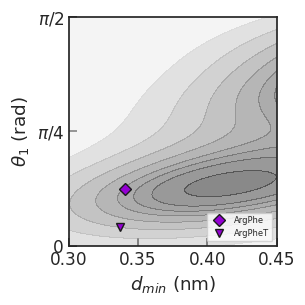

In [37]:
xmin = 0.3; xmax = 0.45
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Phe' in v['pdb'] and 'Arg' in v['pdb']:
        color = 'darkviolet'
        symbol = 'D'
        if 'PheT' in v['pdb']:
            symbol = 'v'
        ax.plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

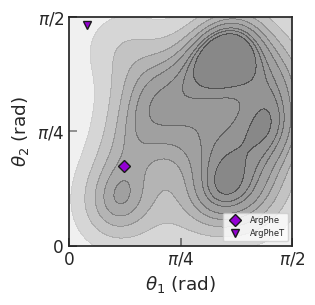

In [38]:
fig, ax = plt.subplots(figsize=(3.35, 3.25))

xmin = 0; xmax = np.pi/2
ymin = 0; ymax = np.pi/2
sns.kdeplot(data=contacts_df[sel], x='theta1', y='theta2', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)
for i,v in contacts_qm_df.iterrows():
    if 'Phe' in v['pdb'] and 'Arg' in v['pdb']:
        color = 'darkviolet'
        symbol = 'D'
        if 'PheT' in v['pdb']:
            symbol = 'v'
        ax.plot(v['theta1'], v['theta2'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks([0, np.pi/4, np.pi/2])
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel(r'$\theta_1$ (rad)')
ax.set_ylabel(r'$\theta_2$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

### Lys-Tyr interactions  

In [39]:
sel = pd.DataFrame([(contacts_df.res_i == 'Y') & (contacts_df.res_j == 'K'), \
                    (contacts_df.res_i == 'K') & (contacts_df.res_j == 'Y')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
7,5NW3A,Y,K,TYR12,LYS28,0.378688,1.234177,NaN,1.506750,NaN,NaN,NaN
30,2VB1A,Y,K,TYR20,LYS96,0.355632,0.552637,NaN,0.747607,NaN,NaN,NaN
40,1US0A,Y,K,TYR48,LYS77,0.311364,0.465353,NaN,1.056846,NaN,NaN,NaN
43,1US0A,Y,K,TYR103,LYS154,0.346777,0.436460,NaN,0.141609,NaN,NaN,NaN
46,1US0A,K,Y,LYS176,TYR177,0.362051,0.567283,NaN,0.968820,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
591,4AYOA,K,Y,LYS204,TYR205,0.344741,0.528852,NaN,0.723957,NaN,NaN,NaN
600,4AYOA,K,Y,LYS284,TYR286,0.361493,0.865965,NaN,0.859463,NaN,NaN,NaN
606,4AYOA,K,Y,LYS324,TYR382,0.284841,0.535887,NaN,1.566015,NaN,NaN,NaN
616,4AYOA,Y,K,TYR390,LYS394,0.352425,0.487346,NaN,0.859733,NaN,NaN,NaN


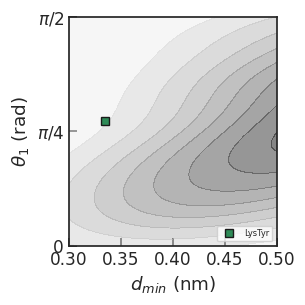

In [40]:
xmin = 0.3; xmax = 0.5
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Tyr' in v['pdb'] and 'Lys' in v['pdb']:
        color = 'seagreen'
        symbol = 's'
        ax.plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

In [41]:

contacts_df[sel][contacts_df[sel]['dvec'] < 0.45]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
43,1US0A,Y,K,TYR103,LYS154,0.346777,0.436460,NaN,0.141609,NaN,NaN,NaN
153,4I8HA,Y,K,TYR184,LYS188,0.363676,0.409489,NaN,0.331104,NaN,NaN,NaN
231,6L27A,Y,K,TYR143,LYS209,0.357152,0.417930,NaN,0.567846,NaN,NaN,NaN
366,2VXNA,K,Y,LYS3,TYR223,0.365924,0.384298,NaN,0.145017,NaN,NaN,NaN
408,8C3XA,Y,K,TYR49,LYS218,0.351186,0.408398,NaN,0.651695,NaN,NaN,NaN
450,4Y9WA,K,Y,LYS24,TYR93,0.368015,0.433885,NaN,0.382742,NaN,NaN,NaN
487,6TGUA,Y,K,TYR51,LYS78,0.369405,0.398237,NaN,0.274685,NaN,NaN,NaN
534,7BNHA,Y,K,TYR402,LYS454,0.394290,0.417206,NaN,0.300653,NaN,NaN,NaN
555,4EICA,K,Y,LYS37,TYR43,0.353662,0.407159,NaN,0.484420,NaN,NaN,NaN
556,4EICA,K,Y,LYS48,TYR56,0.361903,0.388771,NaN,0.408848,NaN,NaN,NaN


### Lys-Phe interactions

In [42]:
sel = pd.DataFrame([(contacts_df.res_i == 'F') & (contacts_df.res_j == 'K'), \
                    (contacts_df.res_i == 'K') & (contacts_df.res_j == 'F')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
1,5D8VA,F,K,PHE64,LYS67,0.422619,0.794475,NaN,1.442892,NaN,NaN,NaN
4,5NW3A,K,F,LYS6,PHE48,0.310219,0.940045,NaN,0.882583,NaN,NaN,NaN
10,5NW3A,K,F,LYS28,PHE29,0.234934,1.239905,NaN,1.535841,NaN,NaN,NaN
11,5NW3A,F,K,PHE29,LYS45,0.261988,0.491446,NaN,0.474389,NaN,NaN,NaN
13,5NW3A,K,F,LYS45,PHE48,0.269305,0.909799,NaN,0.546820,NaN,NaN,NaN
17,3X2MA,F,K,PHE33,LYS124,0.376188,0.728924,NaN,1.435878,NaN,NaN,NaN
26,2VB1A,K,F,LYS1,PHE3,0.360903,0.487941,NaN,0.204604,NaN,NaN,NaN
31,2VB1A,K,F,LYS33,PHE34,0.372143,0.627034,NaN,0.522239,NaN,NaN,NaN
32,2VB1A,K,F,LYS33,PHE38,0.370754,0.586288,NaN,0.676368,NaN,NaN,NaN
53,1US0A,K,F,LYS242,PHE278,0.361252,0.528746,NaN,0.823626,NaN,NaN,NaN


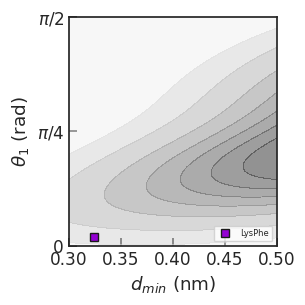

In [43]:
xmin = 0.3; xmax = 0.5
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Phe' in v['pdb'] and 'Lys' in v['pdb']:
        color = 'darkviolet'
        symbol = 's'
        ax.plot(v['dmean'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
                
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()